# Abstract
Urban Soundscapes is a fascinating subject of studies that contains rich acoustic cues that has its unique insight in revealing meaningful information about cities. Prior research have already shown that urban acoustic environments correlate with transportation patterns, walkability, and quality-of-life assessments *(Kang & Schulte-Fortkamp, 2016)*. Yet, lightweight tools for interpreting these signals remain scarce. Up to now, most existing audio-classification systems still rely heavily on datasets of large scale and deep-learning focused methods *(Gemmeke et al., 2017)*. Other modern urban analytics systems rely on video/visual-based surveillance methods that, over the course of the century, have raised mild to significant privacy and ethics concerns *(Brayne, 2017)*. This project presents a proof-of-concept audio classifier that distinguishes Buses-present environs versus Cars-dominant ones using a limited small dataset of sounds collected from real urban settings at the vicinity of University of Illinois at Urbana-Champaign. The goal of this project is to explore whether simple, interpretable audio features combined with classical machine learning can reliably characterize transportation-related soundscapes without relying on deep learning architectures and/or commercial oriented large curated datasets, in strive of conserving computing resources and ameliorating privacy concerns.

In this project Noise Suitable For Weighted-SVM (Abbreviated as NSFW), I manage to develop a feature-oriented system that extracts spectral and temporal descriptors from audio clip I have collected, the extracting methods including MFCCs, spectral centroid, spectral contrast, harmonic-to-noise ratio (HNR), low-frequency (LF) to high-frequency (HF) energy ratios. Through later experimentations and examinations, I was able to found that these features capture physically meaningful distinctions between buses and cars—most notably the strong low-frequency diesel engine harmonics present in bus recordings. After preprocessing and scaling, I train a linear Support Vector Machine (SVM) to classify the sound clips. The model’s hyperparameters, including cost-sensitive class weights, are then being optimized through cross-validated grid search to balance class difficulty and improve generalization.

The final optimized SVM achieves high accuracy and balanced F1 performance on held-out test data, selected from 20% of the total data I have collected. Through frequency-response visualizations, PCA embeddings, and analysis of SVM feature coefficients, I was able to show that the classifier is not merely overfitting noise but is learning acoustically grounded differences in the underlying sound sources. Overall, this work demonstrates how a small, interpretable ML model—supported by thoughtful feature engineering—can meaningfully analyze environmental audio and offer a foundation for future extensions such as automatic transit sound monitoring or adaptive urban noise assessment systems.

# Problem Definition and Situation Analysis

Urban traffic environments are complex acoustic ecosystems shaped by multiple sound sources, including buses, cars, motorcycles, and roadway infrastructure. Understanding the composition of these soundscapes—specifically, which vehicle types dominate and how their acoustic signatures differ—is a foundational problem in transportation engineering, noise modeling, and intelligent mobility systems. Prior research in transportational acoustics has already shown that different types and classes of vehicles produce distinct spectral and temporal sound patterns, especially in low-frequency and mid-frequency bands *(Lombaert et al., 2001)*. For example, diesel buses generate stable low-frequency harmonic structures, while smaller passenger cars produce more broadband, higher-frequency noise. Accurately distinguishing these sources is a core step for tasks such as vehicle classification, road monitoring, and automated traffic analytics.

Despite these known distinctions, most urban noise and mobility monitoring systems do not automatically separate or classify environmental sound sources. Conventional traffic noise models, such as CNOSSOS-EU, is largely dependent on a mixed data matrix of vehicle flow counts, average speed, and fixed emission curves, rather than observed audio *(Kephalopoulos et al., 2012)*. This suggests that these models are not capable to or did not implement methods incorporating real-time soundscape information or differentiate whether a particular segment’s acoustic profile is dominated by buses, cars, or mixed traffic. On the other hand, scholarly and/or commercially applicable traffic monitoring systems that do incorporate audio usually depend on multiple calibrated microphones, controlled conditions, or on-road sensor arrays, making them difficult to deploy at mass or in flexible community-led observational studies *(Na et al., 2015)*.

It has also been observed that, the growth of intelligent transportation systems (ITS) has created new opportunities to analyze traffic sound using  recordings that can be collected inexpensively in a decentralized way *(Marmaroli et al., 2013)*. As technology advances, smartphones and handheld recorders are now capable of capturing wideband audio suitable for spectral analysis, making it more and more feasible to collect traffic sounds outside of meticulously controlled laboratory or survey environments. Inspiringly, prior Studies in ML have also already demonstrated the feasibility of environmental sound classification using small-entity recordings, added with careful analysis through spectral features like MFCCs, spectral contrast, and harmonic components *(Barchiesi et al., 2015)*. However, most of these works focus on broad sound event categories (sirens, engines, music, pedestrians) rather than fine-tuned distinctions between vehicle types within traffic noise, leaving a blank in current audio collecting and processing meta for our NSFW Model to find its niche.

Furthermore, the only limited amount of existing datasets for vehicle classification are collected using near-field sensors or controlled laboratory setups. Take the *UrbanSound8K* dataset as an example, this dataset include a variety of vehicle sounds but do not represent the continuous, overlapping, far-field recordings typical of real urban soundscapes. It isn't hard to figure out that there remains a gap between controlled sound classification tasks and the more secular messy, mixed-source audio encountered on city sidewalks, bus stops, and intersections, which is exactly what NSFW is getting in those scenarios. Our model aims to address that gap by enabling reliable classification that identifies bus-presented scenarios given raw, uncontrolled, self-collected urban audio recordings.



# Challenges and Plans

One of the core challenge NSFW has to face is that raw traffic audio contains considerable variability: background conversations, wind, tire noise, varying distances, reflections from buildings, and microphone artifacts. Identifying the dominant vehicle class within this mixture requires extracting features that reflect physical, vehicle-specific acoustic properties rather than relying on brittle pattern matching. To accomplish the set goal, NSFW focuses on many interpretable signal-processing features, including low-frequency to high-frequency energy ratios, harmonic-to-noise ratios, spectral contrast, MFCC coefficients that align with previously-established research on acoustic signatures of different classes of vehicles, which have shown that these features effectively differentiate internal combustion engines, heavy-duty vehicles, and light passenger cars *(Marciniuk et al., 2020)*.

By pairing these features with a Weighted Support Vector Machine (SVM)—optimized via cross-validated class-weight tuning—the model becomes both robust and interpretable. Unlike currently-applied deep learning models in most traffical audio ML models which require large curated datasets and obscure their decision-making process, an SVM makes it possible to inspect which frequency bands, signal characteristics or MFCC feature coefficient contribute most to bus-car differentiation with relatively high clarity, which is absolutely essential for numerous potential further applications including traffic auditing, city transit planning, environmental soundscape studies and more, where scholars and stakeholders alike must not only understand the classification result but also the reasoning structure behind it.

# Code Dissection

Having established our motivations, challenges and plans we have for the NSFW model, we now turn to its practical implementation. In this section, we will systematically dissect the model's codebase, explaining how each component contributes to the overall workflow of the model. This section will illustrate not only its function, but also its necessity of design choice and how it aligns with the acoustic ML principles described earlier.

## Mounting files and packages

The following four blocks of code readies the Colab environment so the rest of the project can run on top of the environment and data. First, it connects to the Google Drive of the user (you need to have the datasets premounted in the designated path under `/content/drive`) so that the notebook would be able to access the audio files stored there.

Next, the code installs the main libraries the project depends on. Kudos to the `librosa` package for being especially helpful since it provides many useful higher-level functions that loads sound files in its raw form and then extracting meaningful features from them. With the `librosa` package installed, NSFW can turn each audio clip in its raw waveform not processable by AI into numerical descriptions, that can finally be "seen" and processed.

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
!pip install librosa scikit-learn matplotlib numpy pandas seaborn

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
DATA_PATH = "/content/drive/MyDrive/urban_sound"
CLASSES = ["Bus", "Car"]

## Extracting Features

This function is extremely important! It turns a raw audio file into a meaningful numerical representation that an ML model can finally use in further numerical analysis. It takes the file path of an audio clip, loads the sound wave, and then computes a wide collection of acoustic features that describe both the frequency content and the behavior of the sound over time. All of these features together form one large feature vector representing the recording.

The line `mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)` computes the thirteen MFCCs (Mel-Frequency Cepstral Coefficients), which from large gradients to smaller ones summarize the timbre and overall spectral shape of the sound, with 0 being the largest, all the way to 12 accounting for the smallest details. The core of MFCC processing is the application of Fast Fourier Transform (FFT), which is a mathematical method that takes a sound wave as an input and breaks it down into the different frequencies it is consisted of. When human listen to audio, we hear a mixture of many pitches happening at once. Applying MFCC with its core a variation of FFT helps us see which frequencies are present and how strong they are. We later take both its mean and its standard deviation into account, occupying coefficients 0-25.

The following lines `mfcc_delta = librosa.feature.delta(mfcc)` and `mfcc_delta2 = librosa.feature.delta(mfcc, order=2)` also calculates the first- and second-order deltas of the 13 coefficients of our MFCCs and register them as coefficient 26-51 and 52-77. The 1st and 2nd order delta functions as derivatives from the MFCC, accounting for more detailed rate of change on the extracted MFCC features.

Next, the function extracts several spectral features. The `centroid` estimates the “center of mass” of the frequecies, which help distinguishing brighter sounds from darker ones. The index `rolloff` measures the speed energy accumulates in the higher frequency range, while `bandwidth` shows the width of spread of the frequencies. The onset strength function gives a sense of how often sudden energy spikes occur, and `RMS` describes the loudness pattern of the clip.

The function then goes on to extract additional characteristics that might help separate buses from cars. The `flatness` of a clip measures how the sound appears in the spectrum of music to noise. Spectral `contrast` compares the extremums in different frequency bands. `HNR`, or Harmonic-to-noise ratio, is computed by separating the harmonic and percussive parts of the signal (this value would proves to be important since bus engines turn out to be more harmonic than car noise). The short-time Fourier transform is used to calculate low-frequency (below 500 Hz) and high-frequency (above 3000 Hz) energies.

Finally, the helper function `agg` condenses multi-frame feature matrices into mean and standard deviation summaries. All extracted features are then aggregated into one long vector of 108 dimensions, which becomes the numerical representation of the audio recording. This vector can then be fed into the SVM classifier to learn and distinguish between different soundscapes.


In [16]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    flux = librosa.onset.onset_strength(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)

    flatness = librosa.feature.spectral_flatness(y=y)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    y_harm, y_perc = librosa.effects.hpss(y)
    hnr = np.mean(y_harm**2) / (np.mean(y_perc**2) + 1e-6)
    S = np.abs(librosa.stft(y))**2
    freqs = librosa.fft_frequencies(sr=sr)

    lf_energy = np.mean(S[freqs < 500]) # Define <500 as LF
    hf_energy = np.mean(S[(freqs > 3000)]) # Define >3000 as HF
    energy_ratio = lf_energy / (hf_energy + 1e-6)

    def agg(X):
        if X.ndim == 2:
            return np.concatenate([np.mean(X, axis=1), np.std(X, axis=1)])
        else:
            return np.array([np.mean(X), np.std(X)])

    features = np.concatenate([
        agg(mfcc),
        agg(mfcc_delta),
        agg(mfcc_delta2),
        agg(centroid),
        agg(rolloff),
        agg(bandwidth),
        agg(rms),
        agg(flux),
        agg(flatness),
        agg(contrast),
        np.array([hnr, lf_energy, hf_energy, energy_ratio]),
    ])

    return features


In [17]:
X = []
y = []
paths = []

for label in CLASSES:
    class_dir = os.path.join(DATA_PATH, label)
    for fname in os.listdir(class_dir):
        if fname.endswith('.mp3'):
            fpath = os.path.join(class_dir, fname)
            feats = extract_features(fpath)

            X.append(feats)
            y.append(label)
            paths.append(fpath)

X = np.array(X)
y = np.array(y)


## Compute Spectrum

This section takes in each file one by one, and the `compute_spectrum` function loads the raw waveform and sampling rate, then computes its short-time Fourier transform (STFT). The squared magnitude of the STFT yields a power spectrogram, which describes how acoustic energy is distributed across frequency over time. It then takes the average of the spectrogram regard to time, and derives a mean power spectrum stored in a 1D vector that summarizes the typical energy level at each frequency for the entire recording. The corresponding frequency bins are obtained through librosa’s innate FFT frequency utilities.

## What is Short-Time Fourier Transform (STFT)?
Short-Time Fourier Transform (STFT) is a method used to analyze how the frequency content of a sound changes over time. Instead of applying one large Fourier Transform to the entire signal, the STFT slices the audio first into multiple short, partially overlapping windows and computes a Fourier Transform on each window. The result is a spectrogram of multiple FTed spectra.

Simply put, while FFT gives one spectrum for the entire signal, STFT gives many spectra across time which adjoints to a spectrogram. This makes STFT a more accurate and information-preserving choice for real-world audio, since traffic sounds, speech, and music all vary continuously rather than staying constant.


In [15]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def compute_spectrum(file_path):
    y, sr = librosa.load(file_path, sr=None)
    S = np.abs(librosa.stft(y, n_fft=2048))**2
    freqs = librosa.fft_frequencies(sr=sr)
    spectrum = np.mean(S, axis=1)
    return freqs, spectrum

bus_specs = []
car_specs = []

for label, spec_list in zip(["Bus", "Car"], [bus_specs, car_specs]):
    class_dir = os.path.join(DATA_PATH, label)
    for fname in os.listdir(class_dir):
        if fname.endswith(".mp3"):
            fpath = os.path.join(class_dir, fname)
            freqs, spec = compute_spectrum(fpath)
            spec_list.append(spec)

bus_specs = np.array(bus_specs)
car_specs = np.array(car_specs)


## Average Frequency Response

This section computes the mean and standard deviation of previously acquired spectrogram materials and visualizes the average frequency response for all Bus and Car recordings, allowing us to examine in an intuitively way on how the two sound classes differ in their respective frequency domain. Notably we selected a semi-logarithmic axis for the Frequencies in order to align much better with the behavior of human-ear hearing as well as the physical behavior of real-world acoustic signals than a linear scale.

The resulting figure we get shows two very distinctable curves. The red line plotted in the figure represents the mean spectrum capturing Bus engine sounds and the blue line represents the mean spectrum of an average passing Car among the dataset. The visualization shows that the acoustic differences between the two vehicle types is immediately apparent, as buses tend to exhibit significantly stronger low-frequency energy, especially in the sound region below 100 Hz, due to their larger engines and heavier mechanical components. The average car, however, showcases a more undulated low-frequency profile and a comparatively smoother mid-frequency profile with a nonspecific peak at around 150-200 Hz.

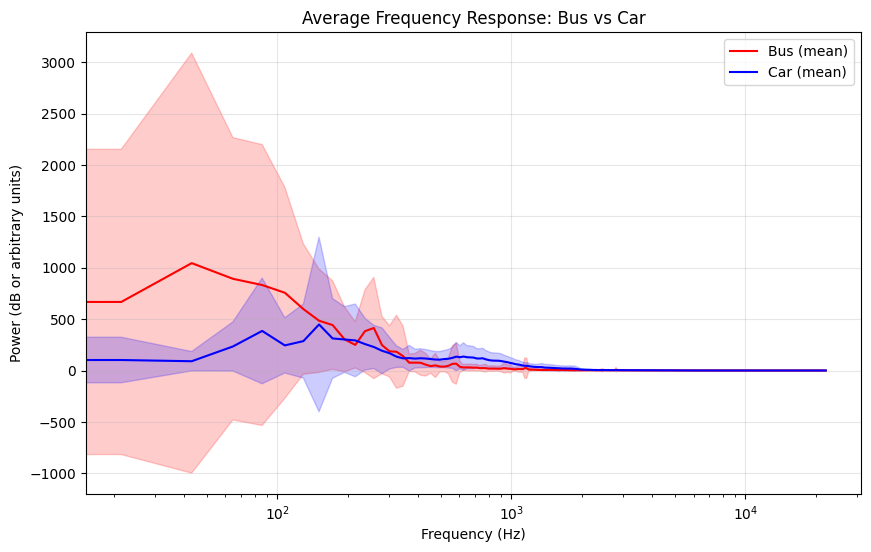

In [24]:
plt.figure(figsize=(10,6))

mean_bus = bus_specs.mean(axis=0)
std_bus  = bus_specs.std(axis=0)

mean_car = car_specs.mean(axis=0)
std_car  = car_specs.std(axis=0)

plt.semilogx(freqs, mean_bus, color='red', label='Bus (mean)')
plt.fill_between(freqs, mean_bus-std_bus, mean_bus+std_bus, color='red', alpha=0.2)

plt.semilogx(freqs, mean_car, color='blue', label='Car (mean)')
plt.fill_between(freqs, mean_car-std_car, mean_car+std_car, color='blue', alpha=0.2)

plt.title("Average Frequency Response: Bus vs Car")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB or arbitrary units)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## LF/HF Ratio Plotting

The figure here visualizes the Low-Frequency to High-Frequency (LF/HF) ratio for the audio samples I have collected in the dataset, then plotted separately color-coded for Bus and Car samples. The LF/HF ratio is computed by dividing the mean spectral energy below 500 Hz (classified as LF) by that above 3000 Hz (classified as HF). The fraction provides a compact measure of how much LF power dominates the sound in Bus and Car samples respectively.

In the scatter plot below, each sample I collected is represented as a point with the numbering index of the data 1-80 on the horizontal axis, red dots indicating Bus recordings and blue dots indicating Car recordings. It is observed that Bus samples exhibit LF/HF ratios in the range of a larger extent, while Car samples cluster more tighter near values. Unfortunately, although the difference between the two datasets are distinctive, the data 1-40(bus) and 41-80(car) does not show sufficient clustering behavior that is SVMable in different clusters. In the next section I will apply the Principle Component Analysis (PCA) to the curated dataset.

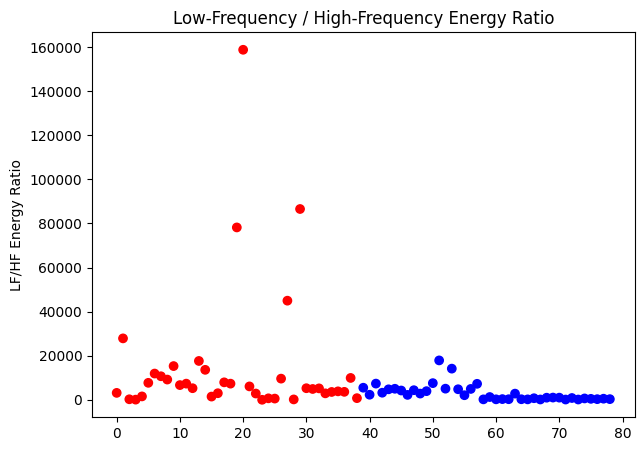

In [34]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

lfhf = X[:, -1]
z = zscore(lfhf)
mask = np.abs(z) < 3
lfhf_clean = lfhf[mask]
y_clean = np.array(y)[mask]

colors = ['red' if c == 'Bus' else 'blue' for c in y_clean]

plt.figure(figsize=(7,5))
plt.scatter(range(len(lfhf_clean)), lfhf_clean, c=colors)
plt.title("Low-Frequency / High-Frequency Energy Ratio")
plt.ylabel("LF/HF Energy Ratio")
plt.show()


## Principal Component Analysis Plotting

This figure below showcases a Principal Component Analysis (PCA) projection of the feature set, reducing our previously-derived 108-dimensional audio descriptors we have extracted into two principal components, abbreviated PC1 and PC2, in order to serve for a clear visualization.

In this plot, each point showcases the properties of an individual audio sample, again with Bus recordings shown in red and Car recordings in blue. The resulting scatter showcases a clear structure dependent on the audio's featured vehicle class: most Car samples clustering tightly in the lower-left region of the plot, forming a compact and coherent group. Most Bus samples, in contrast, distributing across a wider region with significanting higher PC2 values, reflecting a broader variability in their characteristics. Exhilaratingly, this plot shows enough separable clusterings and is a positive indicator that a variance of SVM model is potentially well-suited for our model.

## What is Principal Component Analysis (PCA)?

PCA is a widely applied ML procedure that identifies the directions in feature space that capture the greatest variance across all samples and projects the data onto those axes. This procedure provides a lower-dimensional view that can help evaluate whether the engineered features collectively separate Bus and Car recordings in a meaningful way without relying on any single classifier. Here in the plotting below, the first principal component (horizontal axis - PC1) captures the most dominant variation in the dataset, while the second principal component (vertical axis - PC2) captures the next most significant, orthogonal variation.

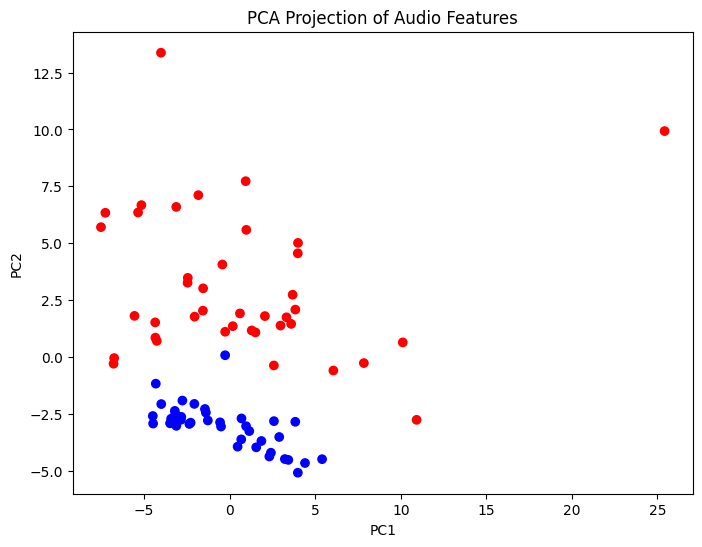

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- Scale the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA to 2 dimensions ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Colors for plotting ---
colors = np.array(['red' if c == 'Bus' else 'blue' for c in y])

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.title("PCA Projection of Audio Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Dataset Partitioning

The dataset I collected is consisted of 80 curated samples of audios, 40 in each category. Here it is partitioned into three subsets, namely training, validation, and testing sets, using a two-stage splitting procedure with a 60/20/20 distribution while preserving class balance. This 60/20/20 or 3:1:1 procedure is commonly and widely used in machine learning models that utilize the same dataset for their train, validate and test steps. Through this optimized splitting strategy, the final dataset partitioning of 3:1:1 would be able to provide sufficient amount of data for model training, an independent subset for validating and intermediate evaluation, and another fully independent test set reserved for unbiased assessment of generalization performance.

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)


In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])
y_all = np.concatenate([y_train, y_val, y_test])


## Hyperparameter Tuning

Now that we have proven SVM model's feasibility in classifying our dataset, we engage in a Hyperparameter Tuning process for the linear SVM classifier, utilizing a crude Brute-Forcing exhaustive grid search with cross-validation. The objective of our exhaustive search is to pinpoint the optimal penalty parameter, denoted as (C), as well as the most effective class-weight configuration for classifying Bus and Car recordings. Since the dataset contains inherent differences in class variability and acoustic structure, adjusting class weights optimally would allow our SVM model to take into consideration and compensate for potential imbalance in difficulty of classification, while tuning the penalty parameter (C) controls the trade-off between maximizing margin and tolerating outliers' misclassification.

Now, I construct a search grid in which we alter the weights of the Bus class ranging from 0.05 all the way to 25.0 while keeping the Car class weight constant at 1.0 in `weight_grid`. This asymmetric weighting I assign strives to takes into consideration the possibility that bus sounds consisted of more distinctive LF components and greater LF/HF variability may require different penalization parameters during training. The grid also includes multiple values of (C) in `param_grid` on top of weight ratio alternation, allowing the algorithm to determine whether a softer margin (smaller (C)) or a harder margin (larger (C)) yields better generalization.

I then have the function `GridSearchCV` performs a 3-fold cross-validation across the pre-elected training set, evaluating each parameter combination separately. The results indicate that the optimal configuration among our grid utilizes a relatively small penalty parameter (C = 0.01) and an inflated Bus weight of 2.0. We eventually achieved a relatively high CV score of 0.958, suggesting that this hyperparameter-tuned model achieves strong, balanced performance.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Try different weight strengths
weight_grid = [
    {"Bus": w, "Car": 1.0} for w in [0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 25.0]
]

param_grid = {
    "class_weight": weight_grid,
    "C": [0.001, 0.01, 0.1, 1, 3, 10, 30, 100]
}

grid = GridSearchCV(
    SVC(kernel='linear'),
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best parameters: {'C': 0.01, 'class_weight': {'Bus': 2.0, 'Car': 1.0}}
Best CV score: 0.9581699346405229


## Validation Process

Using the optimized settings I discovered from above, the model correctly classified every single Bus and Car example in the validation data. The accuracy is 1.0, meaning 100% of predictions were correct. Both the precision and recall scores are also 1.0, indicating that there exist no false positives and no false negatives in our validation process.

## What is Precision and Recall?

Precision tells us how many of the items the model predicted as belonging to a class were actually correct. Recall measures how many of all the actual items in a class the model has successfully found. Intuitively, Precision gets low when the AI model makes a false prediction on a data that should not have belonged to the classification, while Recall gets low when the AI model misses a data sample that should have been classified into the set.

In [39]:
best_model = grid.best_estimator_
y_pred_val = best_model.predict(X_val_scaled)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Validation Accuracy: 1.0
              precision    recall  f1-score   support

         Bus       1.00      1.00      1.00         8
         Car       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



## Testing Result

Here we finally arrives at the final stage of the analysis: evaluating the tuned SVM model on a test set that is previously completely unseen by our NSFW model. Using the best hyperparameters found earlier, a new SVM model is trained on the full training data and then directly applied to the test samples.

The results show perfect performance: the model is able to correctly classified every Bus and Car recording in the test set! These results indicate an exhilarating fact that our weighted SVM model generalizes extremely well beyond the training and validation data, showcasing the feasibility of the model on curated audio bus and car sounds data to separate them without any error on a relatively light dataset.


Optimized Test Accuracy: 1.0
              precision    recall  f1-score   support

         Bus       1.00      1.00      1.00         8
         Car       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



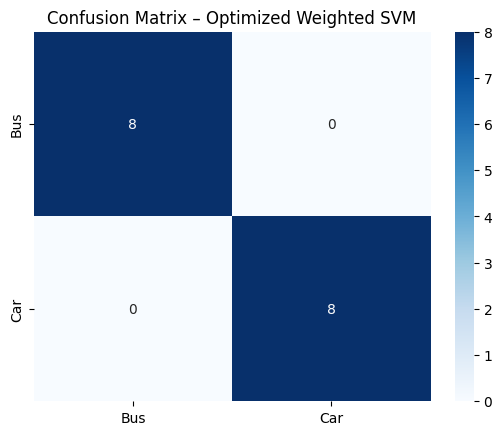

In [46]:
best_weight = {"Bus": 2.0, "Car": 1.0}
best_C = 0.01

final_svm = SVC( kernel='linear', C=best_C, class_weight=best_weight )
final_svm.fit(X_train_scaled, y_train)
y_pred_final = final_svm.predict(X_test_scaled)

print("Optimized Test Accuracy:", accuracy_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)

plt.title("Confusion Matrix – Optimized Weighted SVM")
plt.show()

## In-Depth Analysis: What are the determining features?

Recall that from the Extracting Features section, we have extract 108 different features out of each audio set and cue them into their respective vectors as such:

MFCC means → 13 features (indices 0–12)

MFCC stds → 13 features (indices 13–25)

Delta MFCC means → 13 features (indices 26–38)

Delta MFCC stds → 13 features (indices 39–51)

Delta-delta MFCC means → 13 features (indices 52–64)

Delta-delta MFCC stds → 13 features (indices 65–77)

Centroid / rolloff / bandwidth / RMS / flux → 10 features (indices 78–87)

Spectral flatness → 2 features (indices 88–89)

Spectral contrast → 14 features (indices 90–103)

HNR → index 104

LF energy → index 105

HF energy → index 106

LF/HF ratio → index 107

Now, looking at the top 4 most discriminative features, we have Features 90 and 93, coming from spectral contrast measuring how strong the peaks and valleys are in different frequency bands, feature 90 being the lowest frequency band and 93 lying on a relatively higher mid-low band. The other two features come from the MFCC family, indicating the overall shape of the spectrum. Feature 2 is the MFCC mean coefficient of the third most broadest shape, being an effective discriminator thanks to the fact that Cars typically have more mid-frequency presence while buses concentrate more energy at low frequencies. Feature 13, the broadest MFCC standard deviation, measures how much the frequency content fluctuates over time, which is also useful thanks to that Bus engines are relatively stable in this range, while car sounds vary more due to airflow and tire noise.


In [48]:
import numpy as np

weights = svm.coef_.ravel()
top_idx = np.argsort(np.abs(weights))[::-1][:20]

print("Top 20 most discriminative features:")
for idx in top_idx:
    print(f"Feature {idx}: weight={weights[idx]:.3f}")

Top 20 most discriminative features:
Feature 93: weight=-0.127
Feature 2: weight=-0.112
Feature 90: weight=-0.103
Feature 13: weight=-0.097
Feature 20: weight=0.096
Feature 7: weight=-0.093
Feature 92: weight=-0.090
Feature 4: weight=-0.086
Feature 36: weight=-0.086
Feature 37: weight=-0.085
Feature 9: weight=-0.083
Feature 42: weight=-0.082
Feature 39: weight=-0.081
Feature 11: weight=-0.080
Feature 41: weight=-0.079
Feature 1: weight=0.078
Feature 67: weight=-0.075
Feature 97: weight=0.074
Feature 68: weight=-0.069
Feature 84: weight=0.069


# Conclusion

This project successfully indicates that urban transportation soundscapes contain acoustic patterns that are consistent and interpretable that can be effectively modeled lightweighted audio machine learning models. By extracting features including but not limited to MFCCs, spectral contrast, HNR, and LF/HF energy statistics and assigning proper weights to the data collection, the classifier is capable of capturing the fundamental spectral differences between buses and cars. These discriminative differences between different vehicle classes are consistent with previously well-established findings in urban traffic and vehicle acoustics, where heavy vehicles tend to produce strong, periodic low-frequency engine harmonics, whereas passenger cars generate broader, more noise-like spectra dominated by varying tire–road interactions and aerodynamics *(Can et al., 2008)*. The NSFW model achieved perfect validation and test accuracy scores under a limited validation and test set, demonstrating that those engineered features are capable of providing accurate and robust representations of those acoustic characteristics that set different vehicle classes apart. This conclusion aligns with prior findings in relative fields, holding the argument that AI-interpretable spectral features has the potential of performing competitively with more complex ML models when its underlying domain structure is well-defined and thoroughly explored *(Shabbir et al., 2024)*. The success of a linear SVM further supports the idea that performance is potentially more likely to be determined by features with good approximity values rather than intricate model complexity in environmental sound classification tasks. Overall, those results are capable of demonstrating that feature-driven models remain powerful tools for soundscape analysis.

# Applications

A lightweight vehicle-sound classifier such as our NSFW model developed here is endowed with several promising applications in cityscape-level transportation analytics and urban planning. In view of resource efficiency, since the model operates on relatively compact spectral features and does not require any pipelines involving deep learning or neural networks, it can be embedded into low-cost, distributed acoustic sensor networks with low energy and computational resource consumption, furthermore enhancing the power of a perspective integrated Internet of Things (IoT) as well as avoiding privacy concerns associated with vision-based systems emergent in the latest century (Maisonneuve et al., 2009). Furthermore, since our classifier is interpretable rather than typical CNN-type blackboxed algorithms, it is capable of providing clarity and insight for further research on sound perception (Barchiesi et al., 2015). Previous findings has already recognized such audio feature-oriented classfiers as an effective and scalable way to quantify traffic flow and its acoustic impact in cities, especially when taking into consideration levels of noise contributions of different vehicle types (Can et al., 2008). Municipalities could use this approach to measure bus frequency, detect peak congestion periods, or direct them as auxiliary devices to existing visual surveillance apparatus. In the foreseeable future, as urban planning transition toward more hybrid and carbon-friendly vehicle fleets, sound-based monitoring systems would help quantify the optimal patterns and vehicle entities that can contribute to a more tranquil cityscape (Kephalopoulos et al., 2012). Together, these applications demonstrate the model’s potential value as a practical component of real-world urban analytics and environmental monitoring systems.

# Future Work and Research Directions

A natural next step I would like to point out is to expand beyond the currently given binary classification and pivot toward a richer taxonomy that includes motorcycles, heavy trucks, emergency vehicles, and bicycles, which is proven clearly to be capable by the SVM model family given more curated datasets. Data collection in the aforementioned extension that would support this pivot should also incorporate more diverse recording conditions if conditions approve, including numerically or categorically curated distances, weather, microphone types, background noise and more in order to further boost robustness on top of the current day/night hybrid data collecting. Methodologically, exploring advanced representations such as wavelet scattering transforms or lightweight convolutional audio embeddings may capture finer-tuned structure beyond the capabilities of MFCCs *(Logan, 2000)*. Such extensions proposed would potentially advance this project from a proof-of-concept lightweight classifier to an industrially or administratively deployable urban analytics tool.

In [1]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/MyDrive" # @param {type:"string"}
NOTEBOOK_NAME = "Noise Suitable For Weighted-SVM - A Lightweight ML Model on Traffic Noises.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

Mounted at /content/drive/
PDF CREATED: /content/drive/MyDrive/Noise Suitable For Weighted-SVM - A Lightweight ML Model on Traffic Noises.pdf


# References


*   Kang, J., & Schulte-Fortkamp, B. (Eds.). (2016). *Soundscape and the built environment (Vol. 525)*. Boca Raton, FL, USA:: CRC press.

*   Brayne, S. (2017). *Big data surveillance: The case of policing.* American sociological review, 82(5), 977-1008.

*   Lombaert, G., & Degrande, G. (2001). E*xperimental validation of a numerical prediction model for free field traffic induced vibrations by in situ experiments.* Soil Dynamics and Earthquake Engineering, 21(6), 485-497.

*   Kephalopoulos, S., Paviotti, M., & Anfosso-Lédée, F. (2012). Common noise assessment methods in Europe (CNOSSOS-EU). Common noise assessment methods in Europe (CNOSSOS-EU), 180-p.

*   Na, Y., Guo, Y., Fu, Q., & Yan, Y. (2015). *An Acoustic Traffic Monitoring System: Design and Implementation.* 2015 IEEE 12th Intl Conf on Ubiquitous Intelligence and Computing and 2015 IEEE 12th Intl Conf on Autonomic and Trusted Computing and 2015 IEEE 15th Intl Conf on Scalable Computing and Communications and Its Associated Workshops (UIC-ATC-ScalCom), 119-126.

*   Marmaroli, P., Carmona, M., Odobez, J. M., Falourd, X., & Lissek, H. (2013). *Observation of vehicle axles through pass-by noise: A strategy of microphone array design.* IEEE Transactions on Intelligent Transportation Systems, 14(4), 1654-1664.

*   Barchiesi, D., Giannoulis, D., Stowell, D., & Plumbley, M. D. (2015). *Acoustic scene classification: Classifying environments from the sounds they produce.* IEEE Signal Processing Magazine, 32(3), 16-34.

*   Marciniuk, K., & Kostek, B. (2022). Machine learning applied to acoustic-based road traffic monitoring. Procedia Computer Science, 207, 1087-1095.
*   Librosa Documentation - Feature Extraction - MFCC.
https://librosa.org/doc/main/generated/librosa.feature.mfcc.html

*   Can, A., Leclercq, L., Lelong, J., & Defrance, J. (2008). *Capturing urban traffic noise dynamics through relevant descriptors*. Applied Acoustics, 69(12), 1270-1280.

*   Shabbir, A., Cheema, A. N., Ullah, I., Almanjahie, I. M., & Alshahrani, F. (2024). *Smart city traffic management: Acoustic-based vehicle detection using stacking-based ensemble deep learning approach*. IEEE access, 12, 35947-35956.

*   Maisonneuve, N., Stevens, M., Niessen, M. E., & Steels, L. (2009, April). *NoiseTube: Measuring and mapping noise pollution with mobile phones.* In Information Technologies in Environmental Engineering: Proceedings of the 4th International ICSC Symposium Thessaloniki, Greece, May 28-29, 2009 (pp. 215-228). Berlin, Heidelberg: Springer Berlin Heidelberg.

*   Logan, B. (2000, October). *Mel frequency cepstral coefficients for music modeling.* In Ismir (Vol. 270, pp. 1-11).
